<center><h1>Jigsaw EDA</h1></center>

Here we are going analyze given Jigsaw data.

let's import some usefull librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation
from collections import Counter, OrderedDict
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import TfidfVectorizer

##Source: https://stackoverflow.com/a/14463362/8211103
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [3]:
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


let's see Missing values first

In [4]:
data.isna().sum().sort_values(ascending=False)/len(data)

muslim                                 0.775536
hindu                                  0.775536
white                                  0.775536
transgender                            0.775536
psychiatric_or_mental_illness          0.775536
physical_disability                    0.775536
other_sexual_orientation               0.775536
other_religion                         0.775536
other_race_or_ethnicity                0.775536
other_gender                           0.775536
other_disability                       0.775536
male                                   0.775536
latino                                 0.775536
jewish                                 0.775536
intellectual_or_learning_disability    0.775536
homosexual_gay_or_lesbian              0.775536
heterosexual                           0.775536
black                                  0.775536
atheist                                0.775536
bisexual                               0.775536
asian                                  0

mostly identity features are missing here, lets start univariant analysis

<h3>target</h3>
Toxicity of given comment between 0 and 1

Text(0.5, 1.0, 'Target PDF')

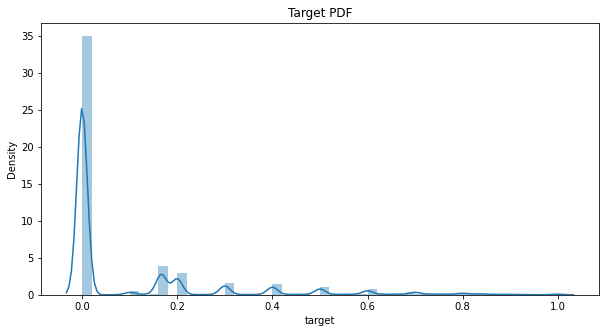

In [5]:
tar = data.target
plt.figure(figsize=(10,5))
sns.distplot(tar)
plt.title('Target PDF')

as per plot we can say that target is right skewed. or look like unbalanced data

In [6]:
print(f"0th percentile values is {np.percentile(tar,0)}")
print(f"25th percentile values is {np.percentile(tar,25)}")
print(f"50th percentile values is {np.percentile(tar,50)}")
print(f"75th percentile values is {np.percentile(tar,75)}")
print(f"90th percentile values is {np.percentile(tar,90)}")
print(f"95th percentile values is {np.percentile(tar,95)}")
print(f"98th percentile values is {np.percentile(tar,98)}")
print(f"99th percentile values is {np.percentile(tar,99)}")
print(f"100th percentile values is {np.percentile(tar,100)}")

0th percentile values is 0.0
25th percentile values is 0.0
50th percentile values is 0.0
75th percentile values is 0.1666666666666666
90th percentile values is 0.4
95th percentile values is 0.6
98th percentile values is 0.7619047619047618
99th percentile values is 0.8333333333333333
100th percentile values is 1.0


90th percentile is 0.4 that means 90% data are less or equal 0.4 or 10% data are greater that 0.4 or in simple word we can say that our data is unbalanced

Text(0.5, 1.0, 'Boxplot')

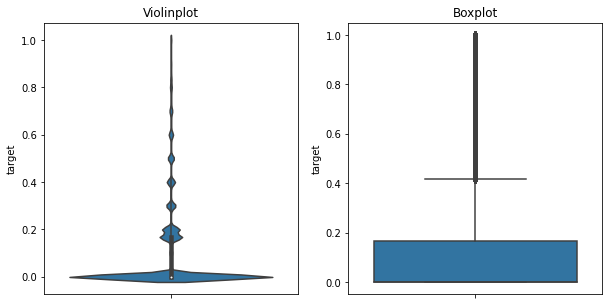

In [7]:
fig,ax =  plt.subplots(1,2,figsize=(10,5))
sns.violinplot(y = tar,ax=ax[0])
sns.boxplot(y = tar,ax=ax[1])
ax[0].set_title('Violinplot')
ax[1].set_title('Boxplot')

as we allready know data is unbalanced and we clearly find out here

Text(0.5, 1.0, 'Count plot')

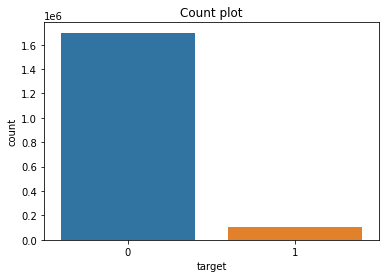

In [8]:
tar = (tar>0.5).astype(int)
sns.countplot(tar)
plt.title('Count plot')

as simple as that data is unbalanced.

In [9]:
del tar

<h3>Comment text<h3>

In [10]:
com_text = data[['comment_text','target']]
com_text.head()

,comment_text,target
0,"This is so cool. It's like, 'would you want yo...",0.000000
1,Thank you!! This would make my life a lot less...,0.000000
2,This is such an urgent design problem; kudos t...,0.000000
3,Is this something I'll be able to install on m...,0.000000
4,haha you guys are a bunch of losers.,0.893617


lets check start with length of comment

0th percentile values is 1.0
25th percentile values is 94.0
50th percentile values is 202.0
75th percentile values is 414.0
90th percentile values is 747.0
95th percentile values is 953.0
98th percentile values is 995.0
99th percentile values is 999.0
100th percentile values is 1906.0


Text(0.5, 1.0, 'Comment length PDF')

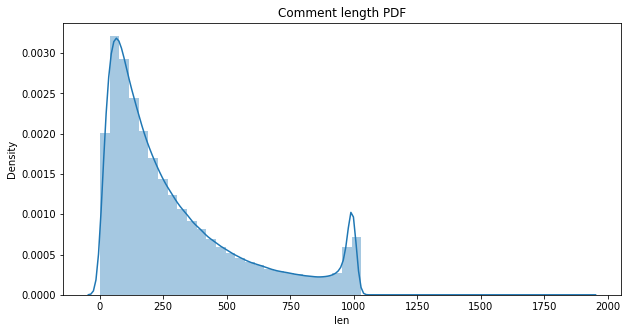

In [11]:
com_text['len'] = com_text['comment_text'].apply(len)

print(f"0th percentile values is {np.percentile(com_text['len'],0)}")
print(f"25th percentile values is {np.percentile(com_text['len'],25)}")
print(f"50th percentile values is {np.percentile(com_text['len'],50)}")
print(f"75th percentile values is {np.percentile(com_text['len'],75)}")
print(f"90th percentile values is {np.percentile(com_text['len'],90)}")
print(f"95th percentile values is {np.percentile(com_text['len'],95)}")
print(f"98th percentile values is {np.percentile(com_text['len'],98)}")
print(f"99th percentile values is {np.percentile(com_text['len'],99)}")
print(f"100th percentile values is {np.percentile(com_text['len'],100)}")

plt.figure(figsize=(10,5))
sns.distplot(com_text['len'])
plt.title('Comment length PDF')

as per above data we can say that 90% of comment length is less than or equal 747

does length of column realte with toxicity? let's see it here

In [12]:
com_text.head()

,comment_text,target,len
0,"This is so cool. It's like, 'would you want yo...",0.000000,101
1,Thank you!! This would make my life a lot less...,0.000000,114
2,This is such an urgent design problem; kudos t...,0.000000,86
3,Is this something I'll be able to install on m...,0.000000,84
4,haha you guys are a bunch of losers.,0.893617,36


Text(0.5, 1.0, 'Comment length PDF')

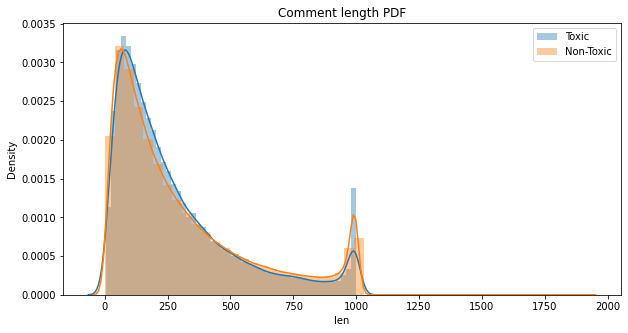

In [13]:
com_text['tar'] = (com_text['target']>=0.5).astype(int)
plt.figure(figsize=(10,5))
sns.distplot(com_text[com_text['tar']>0]['len'],label='Toxic')
sns.distplot(com_text[com_text['tar']==0]['len'],label='Non-Toxic')
plt.legend()
plt.title('Comment length PDF')

can not see much difference in length between toxic and non-toxic, the length might not help to predict toxicity, let's apply model analysis and get final conclusion.

Here we have target categorical data so, let's try t-test to check corelation between target and length feature

In [14]:
_, p = ttest_ind(com_text['len'], com_text['tar'], equal_var=False)
print(f"P-Value of T-test is : {p}")

P-Value of T-test is : 0.0


here we got p-value 0 that means there is no co-relation between these features.

does a number of capital, punctuation, emojis, spaces, words matter to toxicity? </br>
Our Answer: No, it won't relate, simple common sense </br>
But data may say something else let's see what data going to tell

In [15]:
def num_of_cap(txt):
    """
    return number of capital char in the given string
    """
    return len(re.findall(r'[A-Z]',txt))

def num_of_punc(txt):
    """
    return number of punctuation in the given string
    """
    return len([v for v in txt if v in punctuation])
    
def num_of_space(txt):
    """
    return number of space in the given string
    """
    ##Source: https://stackoverflow.com/a/33864536/8211103
    return txt.count(" ")
    
def num_of_emo(txt):
    """
    return number of emojis in the given string
    """
    ## Source : https://stackoverflow.com/a/19149591/8211103
    return len(re.findall(r'[\U0001f600-\U0001f650]', txt))

def num_of_words(txt):
    """
    return number of words in the given string
    """
    return len(txt.split())

In [16]:
com_text['cap'] = com_text['comment_text'].apply(num_of_cap)
com_text['punc'] = com_text['comment_text'].apply(num_of_punc)
com_text['space'] = com_text['comment_text'].apply(num_of_space)
com_text['emo'] = com_text['comment_text'].apply(num_of_emo)
com_text['words'] = com_text['comment_text'].apply(num_of_words)

In [17]:
com_text.head()

,comment_text,target,len,tar,cap,punc,space,emo,words
0,"This is so cool. It's like, 'would you want yo...",0.000000,101,0,3,9,18,0,19
1,Thank you!! This would make my life a lot less...,0.000000,114,0,3,7,21,0,22
2,This is such an urgent design problem; kudos t...,0.000000,86,0,2,3,15,0,16
3,Is this something I'll be able to install on m...,0.000000,84,0,3,3,16,0,17
4,haha you guys are a bunch of losers.,0.893617,36,1,0,1,7,0,8


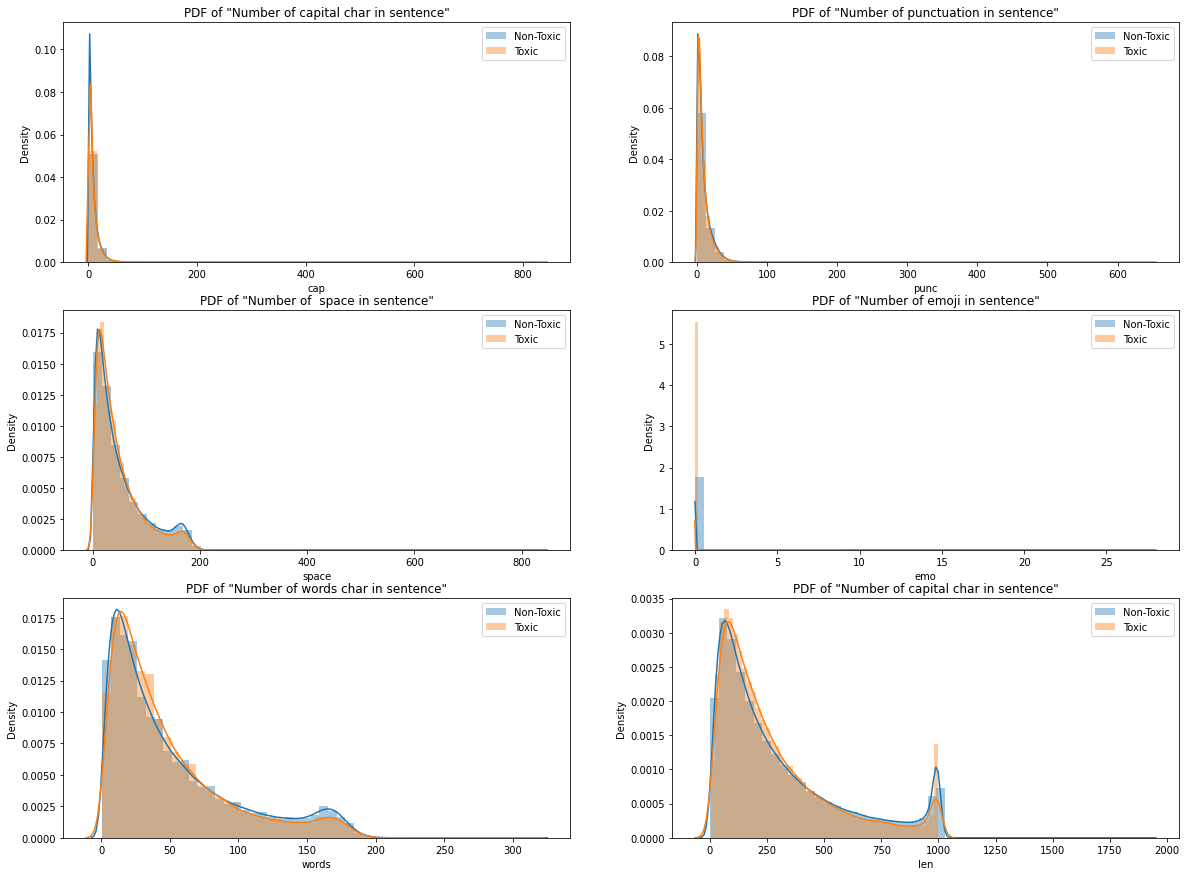

In [18]:
def plot(ax,feat,title):
    sns.distplot(com_text[com_text['tar']==0][feat],label='Non-Toxic',ax=ax)
    sns.distplot(com_text[com_text['tar']==1][feat],label='Toxic',ax=ax)
    ax.set_title(title)
    ax.legend()

fig,ax =  plt.subplots(3,2,figsize=(20,15))
plot(ax[0][0],'cap','PDF of "Number of capital char in sentence"')
plot(ax[0][1],'punc','PDF of "Number of punctuation in sentence"')
plot(ax[1][0],'space','PDF of "Number of  space in sentence"')
plot(ax[1][1],'emo','PDF of "Number of emoji in sentence"')
plot(ax[2][0],'words','PDF of "Number of words char in sentence"')
plot(ax[2][1],'len','PDF of "Number of capital char in sentence"')

here all the features's PDF is overlaping,look like these feature are not matters much to toxicity </br>
let's look relation on number

Now, let's look on most frequent words

In [19]:
com_text['comment_text'] = com_text['comment_text'].apply(lambda x : re.sub("[^a-zA-Z]+", " ", x))
com_text['comment_text'] = com_text['comment_text'].apply(lambda x : x.lower())
## Source: https://stackoverflow.com/a/1546244/8211103
com_text['comment_text'] = com_text['comment_text'].apply(lambda x : re.sub(' +', ' ',x))

100%|██████████| 144334/144334 [00:00<00:00, 150662.67it/s]


Text(0.5, 1.0, 'Word counts for toxic comment')

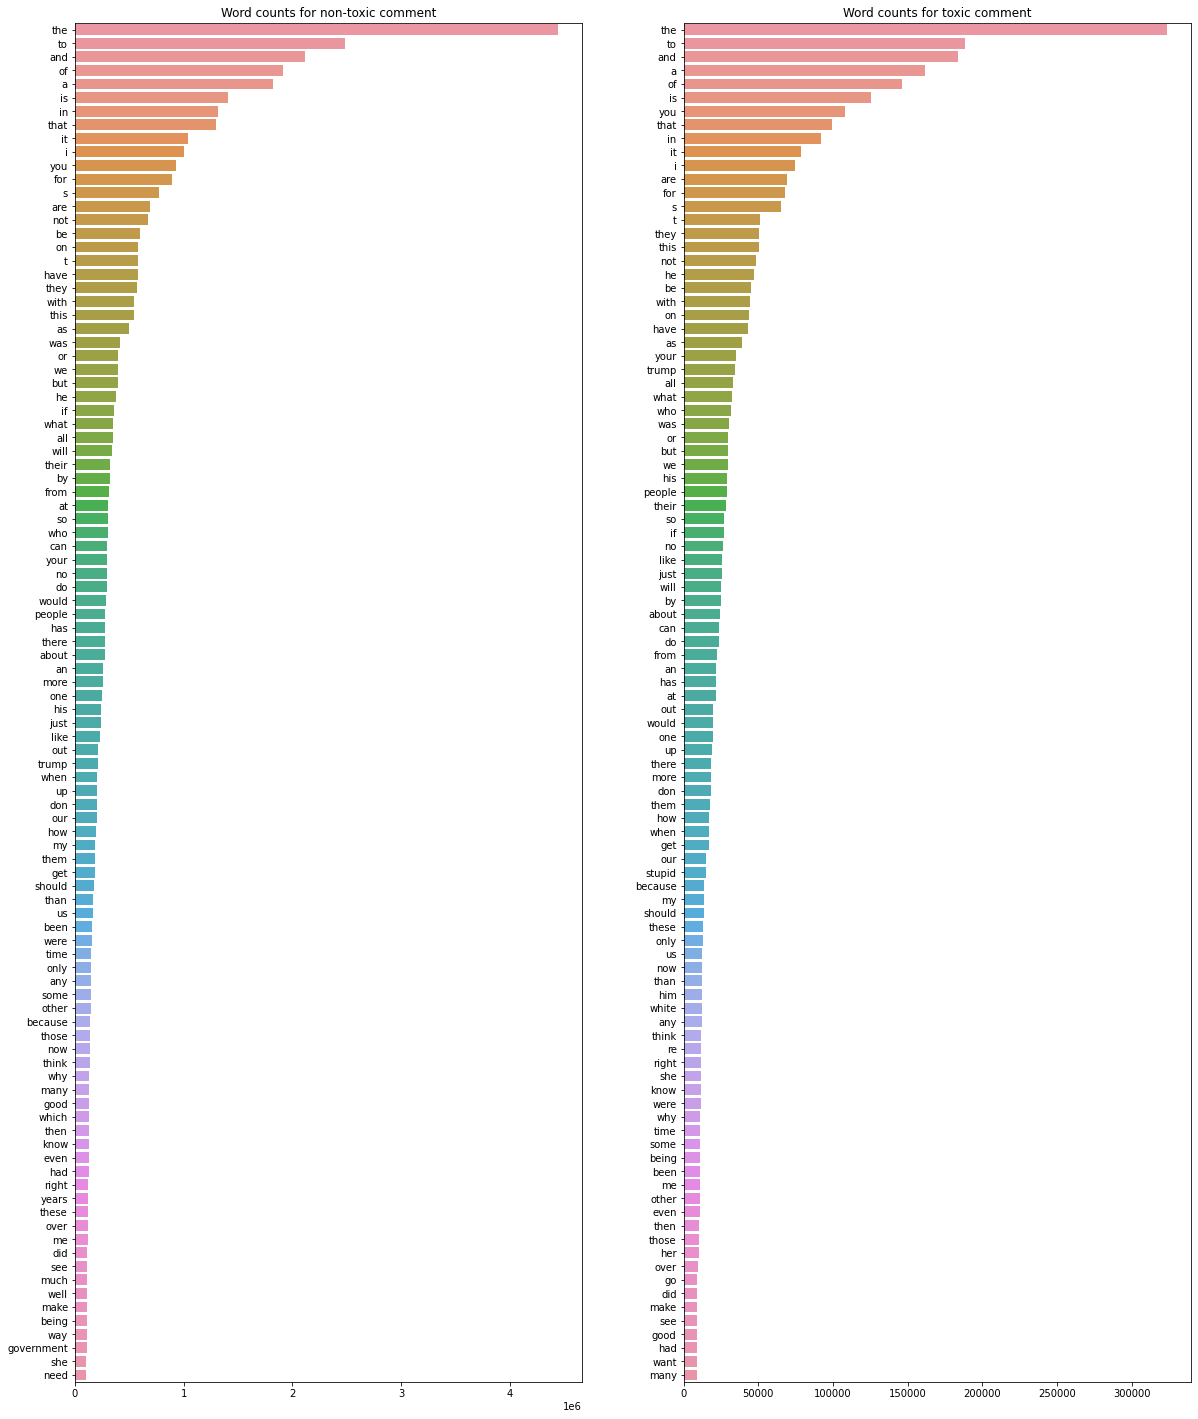

<Figure size 720x1800 with 0 Axes>

In [20]:
fig,ax =  plt.subplots(1,2,figsize=(20,25))

nontoxic_words = []
for txt in tqdm(com_text[com_text['tar']==0]['comment_text']):
    nontoxic_words.extend(txt.split())
    
count = Counter(nontoxic_words)
top_words = {k:v for k,v in count.most_common(100)}
# plt.figure(figsize=(10,25))
sns.barplot(x = list(top_words.values()),y = list(top_words.keys()),ax=ax[0])
ax[0].set_title('Word counts for non-toxic comment')


toxic_words = []
for txt in tqdm(com_text[com_text['tar']==1]['comment_text']):
    toxic_words.extend(txt.split())
    
count = Counter(toxic_words)
top_words = {k:v for k,v in count.most_common(100)}
plt.figure(figsize=(10,25))
sns.barplot(x = list(top_words.values()),y = list(top_words.keys()),ax=ax[1])
ax[1].set_title('Word counts for toxic comment')

here we can see that most words are stop words, and can not see much diffrence between toxic and non-toxic data, lets plot wordplot using Wordcloud.

does rare words contribute to target? let's findout it.

In [21]:
vect = TfidfVectorizer()
vect.fit(com_text['comment_text'])

TfidfVectorizer()

In [22]:
print(f"0th percentile values is {np.percentile(vect.idf_,0)}")
print(f"25th percentile values is {np.percentile(vect.idf_,25)}")
print(f"50th percentile values is {np.percentile(vect.idf_,50)}")
print(f"75th percentile values is {np.percentile(vect.idf_,75)}")
print(f"90th percentile values is {np.percentile(vect.idf_,90)}")
print(f"95th percentile values is {np.percentile(vect.idf_,95)}")
print(f"98th percentile values is {np.percentile(vect.idf_,98)}")
print(f"99th percentile values is {np.percentile(vect.idf_,99)}")
print(f"100th percentile values is {np.percentile(vect.idf_,100)}")

0th percentile values is 1.3206275722193104
25th percentile values is 13.326560353593685
50th percentile values is 14.30738960660541
75th percentile values is 14.712854714713576
90th percentile values is 14.712854714713576
95th percentile values is 14.712854714713576
98th percentile values is 14.712854714713576
99th percentile values is 14.712854714713576
100th percentile values is 14.712854714713576


as we can see here aroutn 50% words are rare. rare 50% means it won't contribute much to targate variable but we need to check perfect relation.

In [23]:
cols = vect.idf_ >= 14.712854714713576
com_text['rare'] = (np.array(vect.transform(com_text['comment_text'])[:,cols].sum(axis=1))>0).astype(int)

<AxesSubplot:xlabel='rare', ylabel='count'>

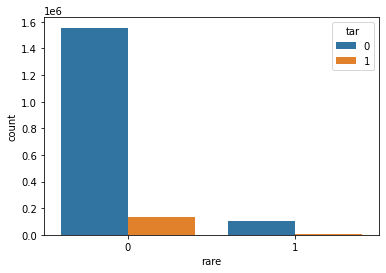

In [24]:
sns.countplot(com_text['rare'],hue=com_text['tar'])

here we can see that rare wors are not affecting much to target feature.

In [25]:
del count
del top_words
del com_text
del vect

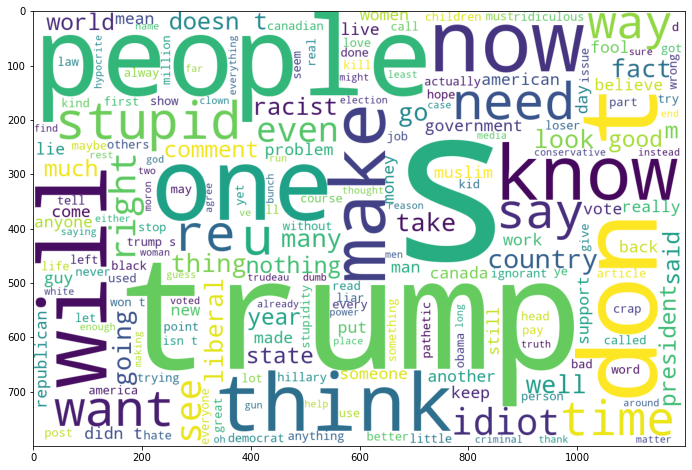

In [26]:
toxic_words = " ".join(toxic_words)
##Source : https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(toxic_words)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)

same thing here showing same as above barplot most frequent words with large font-size

In [27]:
del toxic_words
del nontoxic_words

<h3>severe_toxicity, obscence, threat, insult, identity_attack, sexual_explicit</h3>
Subtypes of Toxicity

In [28]:
subtype = data[["severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit","target"]]
subtype.isna().sum()

severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
target             0
dtype: int64

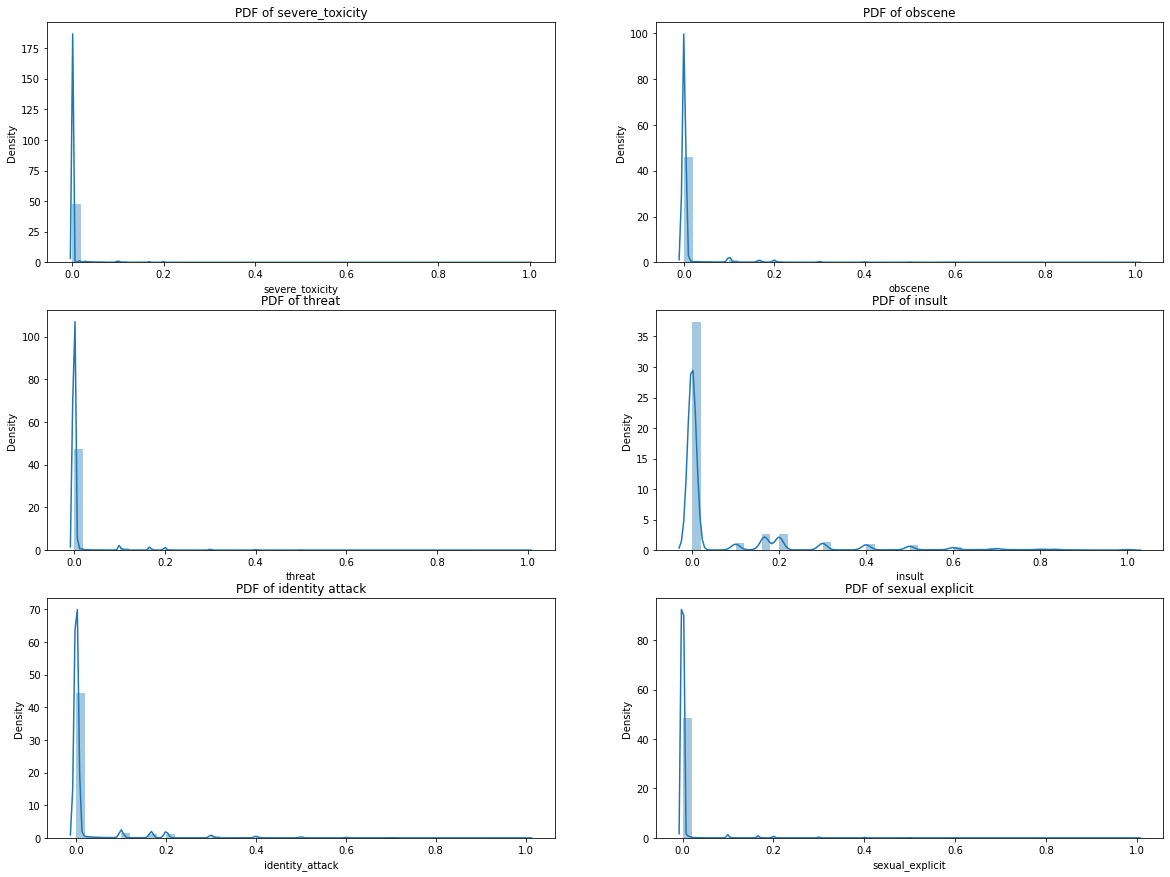

In [29]:
def plot(ax,feat,title):
    sns.distplot(subtype[feat],ax=ax)
    ax.set_title(title)
    
fig, ax = plt.subplots(3,2,figsize=(20,15))
plot(ax[0][0],'severe_toxicity','PDF of severe_toxicity')
plot(ax[0][1],'obscene','PDF of obscene')
plot(ax[1][0],'threat','PDF of threat')
plot(ax[1][1],'insult','PDF of insult')
plot(ax[2][0],'identity_attack','PDF of identity attack')
plot(ax[2][1],'sexual_explicit','PDF of sexual explicit')

look like all th subtypes are right-skewed or it is because of data unbalance.

lets round off data and plot bar plot

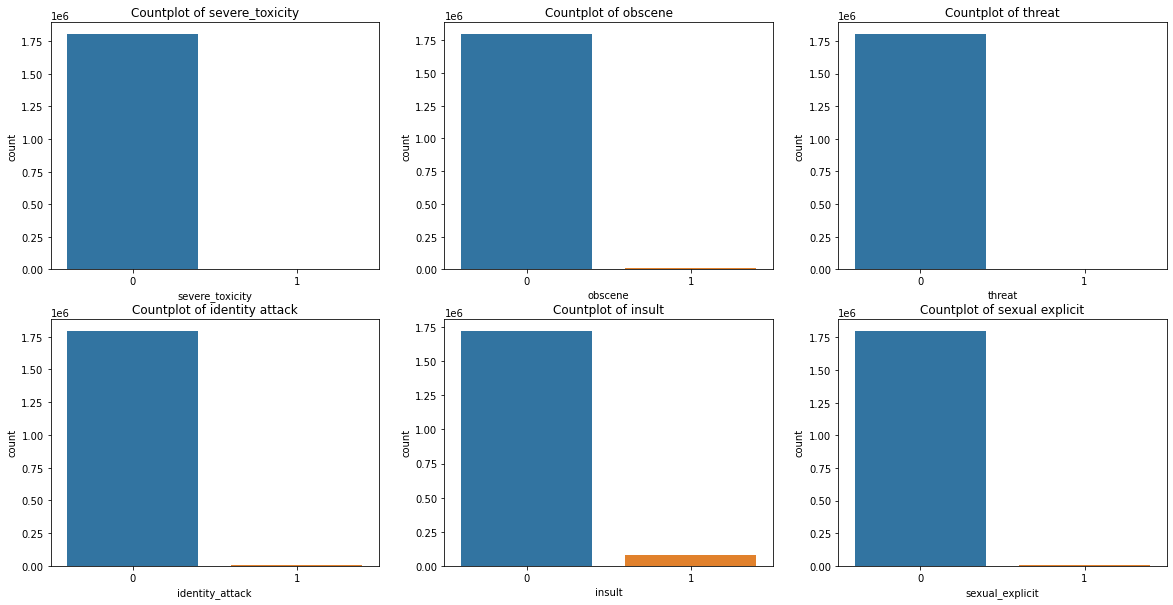

In [30]:
subtype = (subtype>.5).astype(int)
def plot(ax,feat,title):
    sns.countplot(subtype[feat],ax=ax)
    ax.set_title(title)
    
fig, ax = plt.subplots(2,3,figsize=(20,10))
plot(ax[0][0],'severe_toxicity','Countplot of severe_toxicity')
plot(ax[0][1],'obscene','Countplot of obscene')
plot(ax[0][2],'threat','Countplot of threat')
plot(ax[1][1],'insult','Countplot of insult')
plot(ax[1][0],'identity_attack','Countplot of identity attack')
plot(ax[1][2],'sexual_explicit','Countplot of sexual explicit')

here we completly see that mostly data are near to 0. </br>

In [31]:
del subtype

In [32]:
list(set(data.columns) - set(["severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit","target","comment_text"]))

['wow',
 'hindu',
 'identity_annotator_count',
 'article_id',
 'homosexual_gay_or_lesbian',
 'publication_id',
 'buddhist',
 'female',
 'atheist',
 'physical_disability',
 'asian',
 'christian',
 'other_disability',
 'other_sexual_orientation',
 'male',
 'psychiatric_or_mental_illness',
 'other_gender',
 'toxicity_annotator_count',
 'parent_id',
 'other_race_or_ethnicity',
 'disagree',
 'white',
 'other_religion',
 'funny',
 'likes',
 'intellectual_or_learning_disability',
 'latino',
 'heterosexual',
 'transgender',
 'muslim',
 'rating',
 'sad',
 'black',
 'id',
 'bisexual',
 'created_date',
 'jewish']

lots of features are still remain to analayze, But we will not going to analaze each of the features we will cover only those feature which we will use in model development or evalution.

<h3>male, female, homosexual_gay_or_lesbian, christian, jewish, muslim, black, white, psychiatric_or_mental_illness</h3>

In [33]:
identity_data = data[['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']]
identity_data.isna().sum()

male                             1399744
female                           1399744
homosexual_gay_or_lesbian        1399744
christian                        1399744
jewish                           1399744
muslim                           1399744
black                            1399744
white                            1399744
psychiatric_or_mental_illness    1399744
dtype: int64

let's drop null rows

In [34]:
identity_data = identity_data.dropna()
identity_data.head()

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


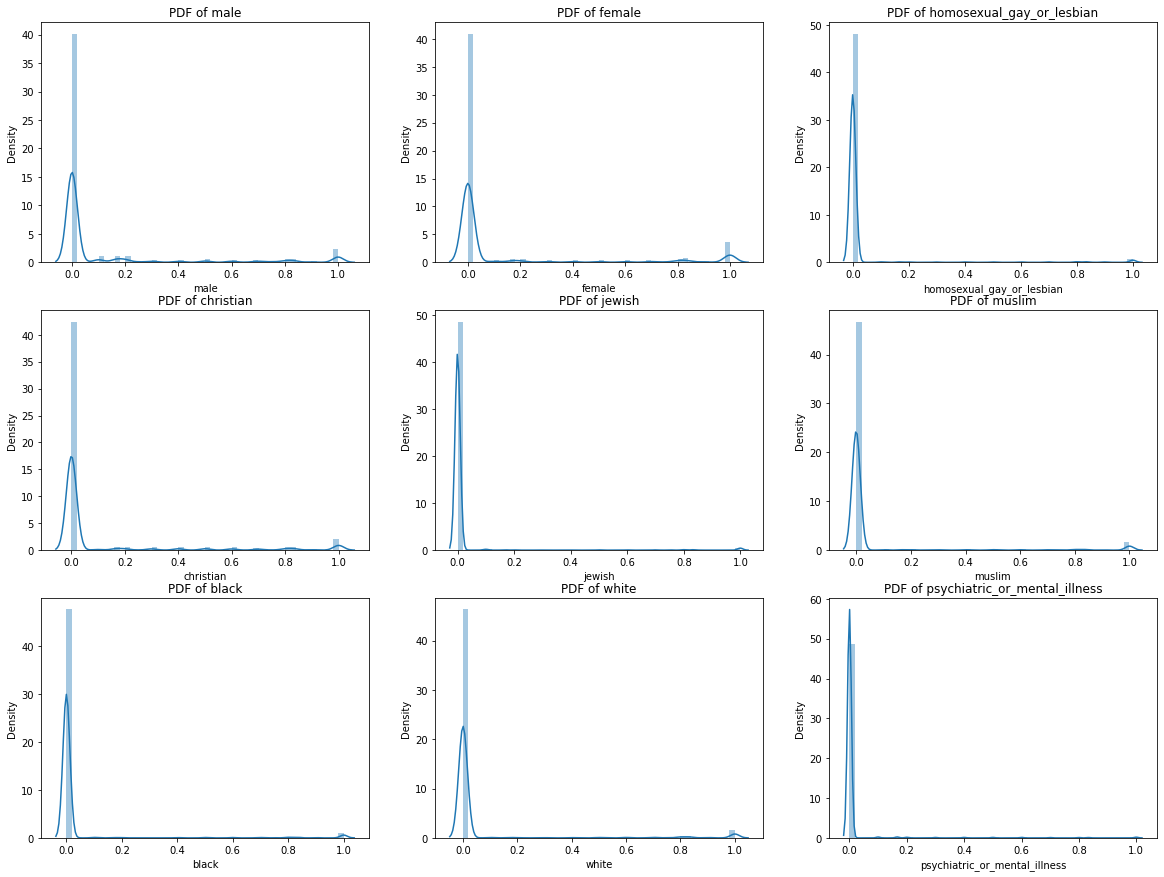

In [35]:
def plot(ax,feat,title):
    sns.distplot(identity_data[feat],ax=ax)
    ax.set_title(title)
    
fig, ax = plt.subplots(3,3,figsize=(20,15))
plot(ax[0][0],'male','PDF of male')
plot(ax[0][1],'female','PDF of female')
plot(ax[0][2],'homosexual_gay_or_lesbian','PDF of homosexual_gay_or_lesbian')
plot(ax[1][0],'christian','PDF of christian')
plot(ax[1][1],'jewish','PDF of jewish')
plot(ax[1][2],'muslim','PDF of muslim')
plot(ax[2][0],'black','PDF of black')
plot(ax[2][1],'white','PDF of white')
plot(ax[2][2],'psychiatric_or_mental_illness','PDF of psychiatric_or_mental_illness')

as we allready know our dat is unbalanced same thing we can see in above plots. lets not plot count plot on this features.

<h2>Conclusion</h2>

* data is highlt unbalanced
* given comments's length,number of words, number of emojis, number of capital char etc are not related with toxicity of sentence.
* as we already know data is highly unbalanced so subtype of toxicity and identity features are also unbalanced.
* mostly ferequent word looks same in both(toxic and non-toxic) so frequency of word data won't work properly like tfidf,BOW .